In [1]:
#Linear Regression Models
#Chapter 3
import numpy as np
import matplotlib.pyplot as plt

In [2]:
#Temp Functions to be deleted
#plots heat map of multi_gauss
def plot_multi_gauss(x,y,mu,covar):
    nbins = 50
    xx,yy = np.mgrid[x.min():x.max():nbins*1j,y.min():y.max():nbins*1j]
    xxyy = np.vstack([xx.flatten(), yy.flatten()]).T
    zz = multi_gauss(xxyy,mu,covar)
    plt.pcolormesh(xx,yy,zz.reshape(xx.shape))
    plt.show()
    
#multi gauss
def multi_gauss(x,mu,cov):
    D = len(mu)
    a = 1.0/(np.power(2*np.pi,D/2.0))

    b = 1.0/(np.power(np.linalg.det(cov),.5))

    c = np.exp((-.5)*(maha_dist(x,mu,cov)))
    return a*b*c

#mahalanobis dist
def maha_dist(x,mu,cov):
    diff = x-mu
    ret = np.matmul(diff,np.linalg.inv(cov))
    ret = np.matmul(ret,diff.T)
    return ret.diagonal()

In [36]:
def sin(x):
    return np.sin(x)

def cos(x):
    return np.cos(x)

def pw(x,n):
    return np.power(x,n)

def Y(x,m,b):
    return (m*x)+b

def sigmoid(x):
    return 1.0/(1+np.exp(-x))

def sigmoid_basis(x,mu,s):
    N = len(mu)
    x = np.outer(np.transpose(x),np.ones(N))
    diff = np.subtract(x,mu)
    return sigmoid((1.0/s)*diff)

def gauss_basis(x,mu,s):
    N = len(mu)
    x = np.outer(np.transpose(x),np.ones(N))
    diff = np.subtract(x,mu)
    n = np.power(diff,2)
    d = 2*np.power(s,2)
    f = (1.0/d)*n
    return np.exp(-f)

#returns wegihts based on zero mean gaussian
def get_weights(numb):
    return np.random.normal(0,.5,numb)

def get_centers(x,n_bfun):
    if len(x) == 1:
        return [x]
    mi = min(x)
    ma = max(x)
    delt = (ma-mi)/n_bfun
    cen = []
    while mi<ma:
        cen.append(mi)
        mi = mi+delt
    return cen

def moore_pen_inv(phi):
    m = np.matmul(np.transpose(phi),phi)
    m = np.matmul(np.linalg.inv(m),np.transpose(phi))
    return m

#The approxiamte function y(x,w) given input x
#weights and basis functions
def approx_y(w,x,c,s,p):
    #N = len(w)
    b = pick_basis(x,c,s,p)
    
    g = np.ones(len(x))
    g = np.insert(b,0,g,1)
    print(np.shape(w),np.shape(g))
    return np.matmul(w,np.transpose(g))


#Returns maximum likelihood weights and basis functions
#for linear regression
#pts is the input points
#n_bf is the number of basis functions
#s is the spatial component of the basis
#v is the type of basis function 1->gauss 2->sigmoid
def max_likelihood_lin_reg(pts,n_bf,s,p):
    x = pts[:,0]
    y = pts[:,1]
    
    c = get_centers(x,n_bf-1)
    g = np.ones(len(x))
    bf = pick_basis(x,c,s,p)
    g = np.insert(bf,0,g,1)
    w = np.matmul(moore_pen_inv(g),y)
    return w,g,c

#Returns maximum likelihood weights and basis functions
#for linear regression with regularization term
#pts is the input points
#n_bf is the number of basis functions
#s is the spatial component of the basis
#p is the type of basis function 1->gauss 2->sigmoid
#rg_fac is the regularization factor 
def max_likelihood_lin_reg_rg(pts,n_bf,s,p,rg_fac):
    x = pts[:,0]
    y = pts[:,1]
    
    c = get_centers(x,n_bf-1)
    g = np.ones(len(x))
    bf = pick_basis(x,c,s,p)
    g = np.insert(bf,0,g,1)
    shp = np.shape(g)
    rg_I = rg_fac*np.eye(shp[1],shp[1],dtype=float)
    
    #calculating weight vector
    a = rg_I+np.matmul(np.transpose(g),g)
    b = np.matmul(np.linalg.inv(a),np.transpose(g))
    w = np.matmul(b,y) 
    return w,g,c

#Returns basis func
def pick_basis(data,c,s,p):
    if (p == 1):
        return gauss_basis(data,c,s)
    elif (p==2):
        return sigmoid_basis(data,c,s)
    
#Parameter Distribution Posterior Estimation
#p(w|t,m_0,s_0)
def weight_dist_post(data,prior_mean,prior_covariance,noise,n_bf,s,p):
    
    x = data[:,0]
    y = data[:,1]
    c = get_centers(x,n_bf)
    phi = pick_basis(x,c,s,p)
    
    #g = np.ones(len(x))
    #phi = np.insert(phi,0,g,1)

    a = noise*np.matmul(np.transpose(phi),phi)

    post_cov_inv = np.linalg.inv(prior_covariance)+a
    
    a = noise*np.matmul(np.transpose(phi),y)
    a = np.matmul(np.linalg.inv(prior_covariance),prior_mean)+a
    post_mean = np.matmul(np.linalg.inv(post_cov_inv),a)
    
    return post_mean,np.linalg.inv(post_cov_inv),c


Len X 1000


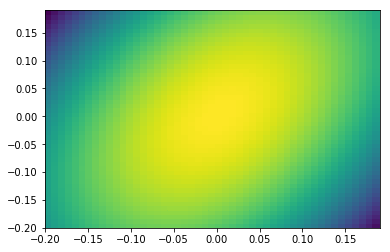

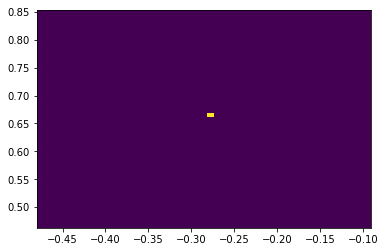

[-0.28021851  0.66280257]
[[  2.75854795e-07  -2.87142072e-08]
 [ -2.87142072e-08   1.38397392e-07]]


In [42]:
x = np.arange(0,3,.003)
print("Len X",len(x))
np.random.shuffle(x)
y = Y(x,0.5,-0.3)
pts = np.stack((x,y),axis=1)


data_n = 1000
n = data_n
s = .5
n_bf = 2
p = 1
m = np.array([0,0])
cov = np.array([[1,3.0/5],[3.0/5,2]])

wx = np.arange(m[0]-2*(.1),(m[0]+2*(.1)),.01)
wy = np.arange(m[1]-2*(.1),(m[1]+2*(.1)),.01)
plot_multi_gauss(wx,wy,m,cov)
while n>0:
    m,cov,c = weight_dist_post(pts[0:data_n],m,cov,25,n_bf,s,p)
    n = n-1

wx = np.arange(m[0]-2*(.1),(m[0]+2*(.1)),.01)
wy = np.arange(m[1]-2*(.1),(m[1]+2*(.1)),.01)
plot_multi_gauss(wx,wy,m,cov)


print(m)
print(cov)
#yy = approx_y(m,x,c,s,p)
#plt.plot(x,y,'.')
#plt.plot(x,yy,'.')
#plt.legend(['True','Estimate'])
#plt.show()
